To start, we import all of the packages that we will need in this notebook. 

In [1]:
import glob
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

# Stage 1: Preprocess The data

### Adding the features we will need to optimize to a DataFrame and then exporting to a csv

Here we read in the well production.csv file 

In [2]:
well_productions = pd.read_csv("well productions/well production.csv")

Here we read in the csv file for each well 

In [3]:
import csv
datas = []
for file in glob.glob("well productions/*"):
    if "well production.csv" not in file:
        frame = pd.read_csv(file)
        # Strip off the extra things on the end
        frame["Name"] = file[17:-4]
        datas.append(frame)

The following function calculates the well length for each well and adds the well length of each well to the DataFrame


In [4]:
def well_length(dataframe: pd.DataFrame):
    dataframe["well length"] = dataframe["easting"].iloc[-1] - dataframe["easting"][0]

The following function calculates the number of frac stages for each well and adds the calculated value to the DataFrame

In [5]:
def frac_stages(dataframe : pd.DataFrame):
    dataframe["frac stages"] = dataframe[dataframe["proppant weight (lbs)"].isna() == False].shape[0]

The following function sets proppant per stage as "ppf." It will default to the maximum weight. 

In [6]:
"""
Sets a proppant per stage as "ppf" defaults to the maximum weight
method can be ["min, "max", "avg"]
"""
def proppant_per_stage(dataframe: pd.DataFrame, method="avg"):
    if method == "min":
        val = min(dataframe["proppant weight (lbs)"])
    elif method == "max":
        val = max(dataframe["proppant weight (lbs)"])
    elif method == "avg":
        val = dataframe["proppant weight (lbs)"].describe()["mean"]
    else:
        raise Exception(f"No method found for {method}")
    dataframe["ppf"] = val

The following function sets pump rate as "pr." It will default to the maximum rate. 

In [7]:
"""
Sets a pump rate as "pr" defaults to the maximum weight
method can be ["min, "max", "avg"]
"""
def pump_rate(dataframe: pd.DataFrame, method="avg"):
    if method == "min":
        val = min(dataframe["pump rate (cubic feet/min)"])
    elif method == "max":
        val = max(dataframe["pump rate (cubic feet/min)"])
    elif method == "avg":
        val = dataframe["pump rate (cubic feet/min)"].describe()["mean"]
    else:
        raise Exception(f"No method found for {method}")
    dataframe["pr"] = val

The below function finds how many years the well will economically produce oil, under the assumption that up to 93 barrels of oil is economical. To arrive at this value we **NEED TO RATIONALIZE THIS VALUE** 

In [8]:
def life_of_res(qi, D):
    lifetime = 1/D*np.log(qi/93)
    if lifetime < 0:
        return 0
    else: 
        return lifetime

exponential loss curve

$ q(t) = q_ie^{-Dt} $

Where $D$ is the decline rate and $q_i$ is the initial rate of production
Exponential decline curve equation

    Arguments:
        t:  Number of months the well has been producing oil 
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        
    Output: 
        Returns q, or the expected production rate at time t. Float.

In [9]:
def exponential_loss(t, qi, D): 
    return qi*np.exp(-D*t)

 $ q(t) = \frac{q_i}{(1+bDt)^{1.0/b}} $
 
 Hyperbolic decline curve equation
 
    Arguments:
        t:  Number of months the well has been producing oil
        qi: Float. Initial production rate when well first came online.
        b:  Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output: 
        Returns q, or the expected production rate at time t. Float.

In [10]:
def hyperbolic_loss(t, qi, b, di):
    return qi/((1.0+b*di*t)**(1.0/b))

This function allows you to look at the first X months of production, and selects the highest production month as max initial production. It returns the max initial production in the first X months along with a series that contains the values of oil production for the first 12 months. 
    
    Arguments:
        number_first_months: int. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        
        well_name: String. name of the well where we're attempting to get
        the max volume from.

In [11]:
def get_max_initial_production(number_first_months, well_name):
    
    row = well_productions.loc[well_productions["well name"] == well_name]
    val=0      
    row = row.filter(regex='oil')
    row=row.T.squeeze()
    
    for i in range(number_first_months):
        val = max(row[i], val)

    return val, row

The below two functions find the defined integral of the fitted exponential and hyperbolic equations between 0 and the calculated life of the reservoir. Our team found that was easier to use an integral then implement the equation fround in the "Hinge Basin" notebook. 

$ N_p = \int_0^{L_t} q(t)dt $ Where $N_p$ is total production and $L_t$ is the lifetime of the well

In [12]:
def get_cumulative_exponential(qi, D):
    return quad(exponential_loss, 0, life_of_res(qi, D), args=(qi,D))

def get_cumulative_hyperbolic(qi, b, di):
    return quad(hyperbolic_loss, 0, life_of_res(qi, di), args=(qi, b, di))

$N_{p} = (\frac{q_{i}}{D})ln(\frac{q_{i}}{q})$

In [13]:
def get_cumulative_other(qi, D, qt):
    t = life_of_res(qi, D)
    q = qt(t, qi, D) # for the exponential equation
    return (qi/D) * np.log(qi/q)

The following function will add the expected lifetime of the well when using the exponential_loss function and the hyperbolic function then add the respective values to the dataframe. Following that, it will find the cumulative production with the least amount of error out of the two functions, and add that value to the DataFrame. 

In [14]:
time_series=pd.Series(list(range(12)))
def cum_production(dataframe: pd.DataFrame, find_min=False):
    #find the name of the current well being examined
    name = dataframe["Name"][0]
    #Set qi equal to the maximum production in the first 5 months of this well's lifespan, and row equal to the series of the 
    #first 12 months' production values
    qi, row = get_max_initial_production(5, name)
    
    #Use the scipy curve_fit function to get the best possible exponential and hyperbolic curves
    popt_exp, pcov_exp = curve_fit(exponential_loss, time_series, row, bounds=(0, [qi,20]))
    popt_hyp, pcov_hyp=curve_fit(hyperbolic_loss, time_series, row,bounds=(0, [qi,2,20]))
    
    #Get the defined integral's value and error for both the exponential and hyperbolic curves
    cp_exp = get_cumulative_exponential(*popt_exp)
    cp_hyp = get_cumulative_hyperbolic(*popt_hyp)

    #Set cumulative production to whichever defined integral has the least error
    if cp_exp[1] < cp_hyp[1]: 
        cum_production = cp_exp[0]
    else: 
        cum_production = cp_hyp[0]

    #Add the respected calculated lifetimes for the exponential and hyperbolic curves to the dataframe then add the 
    #calculated cumulative production. 
    dataframe["lifetime_exp"] = life_of_res(*popt_exp)
    dataframe["lifetime_hyp"] = life_of_res(popt_hyp[0], popt_hyp[2])
    dataframe["cum_production"] = cum_production
    
    
    dataframe["cum_production_other"] = get_cumulative_other(popt_exp[0], popt_exp[1], exponential_loss)


Here we call all of the functions we wrote that add the values we will need to optimize to the DataFrame 

In [15]:
%%capture
list(map(cum_production, datas))
list(map(well_length, datas))
list(map(frac_stages, datas))
list(map(proppant_per_stage, datas))
list(map(pump_rate, datas))

Here we drop the duplicate wells from the dataframe

In [16]:
%%capture
big_df = pd.concat(datas)
## Removing duplicates makes graphing well locations significantly harder. Remove duplicates when regressing
# big_df.drop_duplicates(subset=['Name'], inplace=True)

Here we export our DataFrame to a new csv file so we no longer need to run preprocessing cells above

In [17]:
big_df.to_csv("bigPoppa.csv", index=False)

# Stage2: Creating a model to predict cumulative output

### Creating a model that uses the features we added to the dataframe to predict cumulative output

**We should finally be able to get to the fun stuff now 😁**

In [18]:
big_df = pd.read_csv("bigPoppa.csv")

In [19]:
data = big_df.drop_duplicates(subset=['Name'])

In [20]:
data["lifetime_exp"].describe() # should be measured in years

count    100.000000
mean      35.994162
std       11.099830
min        0.072446
25%       30.127467
50%       37.639081
75%       43.862433
max       52.483608
Name: lifetime_exp, dtype: float64

In order to apply any sort of regression to our data, we must first clean our data and remove all non-numerical values that will not add any specific input into our final predictions. For this dataset, we see that the Names column along with any rows that have NaN/Infinity/Empty data should not be included in our model. Therefore, we will remove these anomalies from our data.

In [21]:
def clean_dataset(df):
    df = df.dropna()
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [22]:
from scipy import stats

Remove outliers on the right...right skewed graph

In [23]:
clean_data = clean_dataset(data.drop(["Name"], axis=1))
clean_data = clean_data[np.abs(stats.zscore(clean_data) < 2.5).all(axis=1)] 

4027

After cleaning our data, we will use all but the cumulative production data in our dataframe to predict our cumulative production for each well.

## Find the Important Features

In [24]:
def feature_importances(model, features_df, thresh=0.1):
    print("  Feature".ljust(36) + "  Score")
    print("-"*60)
    for i, feature in enumerate(model.feature_importances_):
        if abs(feature) >= thresh:
            print("| ", end="")
            print(f"{features_df.columns[i]}".ljust(36), end="|")
            print(f"{feature}".ljust(20), end="")
            print(" |")
            print("-"*60)

In [25]:
def graph_acuracy(x, y, data, model, feature):
    plt.scatter(x[feature], rf.predict(x), label="Prediction")
    plt.scatter(x[feature], y, label="Acutal")
    plt.xlabel(f"{feature} value")
    plt.ylabel("Cumulative production")
    plt.legend()

In [26]:
def graph_accuracy_importances(x, y, model, data, importances, thresh=0.1):
    for i, feature in enumerate(importances):
        if abs(feature) >= thresh:
            feat_name = x.columns[i]
            graph_acuracy(x, y, data, model, feat_name)
            plt.title(f"Acuracy of {feat_name} - Importance {feature}")
            plt.show()

In [27]:
from yellowbrick.regressor import ResidualsPlot

def show_residusal(model, train_tup, test_tup):
    resPlot = ResidualsPlot(model)
    resPlot.fit(*train_tup)
    resPlot.score(*test_tup)
    resPlot.show()

In [28]:
!pip install yellowbrick

In [29]:
data.head()

,easting,northing,porosity,permeability,Poisson's ratio,Young's Modulus,water saturation,oil saturation,proppant weight (lbs),pump rate (cubic feet/min),Name,lifetime_exp,lifetime_hyp,cum_production,cum_production_other,well length,frac stages,ppf,pr
0,17800.0,32000.0,0.06,0.013,0.343,8.571816e+06,0.298794,0.701206,914250.711822,293.505526,King 13-215H,35.661322,35.661469,28120.142308,98746.199743,8287.0,50,834045.771760,305.935717
100,84500.0,37600.0,0.06,0.015,0.340,1.097546e+07,0.286440,0.713560,406263.949202,229.721504,Burger 6-148H,36.412177,36.411952,30410.811545,108945.234952,4369.0,25,665411.365610,301.840799
200,32000.0,12500.0,0.04,0.007,0.348,9.665325e+06,0.036704,0.963296,116734.353830,311.613745,Federal 8-166H,44.131368,44.130933,68049.703631,295018.197124,6010.0,50,707865.008407,309.432759
300,57400.0,52200.0,0.06,0.015,0.329,1.221196e+07,0.161848,0.838152,300144.867355,352.917530,Sutherland 1-11H,45.681298,45.681582,78756.147833,352157.129815,8198.0,50,661607.838265,302.966963
400,69000.0,81100.0,0.06,0.016,0.346,1.009616e+07,0.162180,0.837820,206065.103608,309.396314,Golden 1-209H,47.574331,47.574825,96620.176567,451290.102608,8813.0,99,682763.982800,296.289311


In [30]:
drop_columns = ['cum_production', 'cum_production_other', 'lifetime_hyp', 'lifetime_exp','frac stages', 'northing']
# Changed this to just look at the values we are supposed to 
x = clean_data.drop(drop_columns, axis = 1)
#x = clean_data[["ppf", "pr", "well length", "frac stages"]]
y = np.log(clean_data['cum_production']) # predict on the ln(cum) hopefully will linearlize it

In [31]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=86)
train, test = (x_train, y_train), (x_test, y_test)

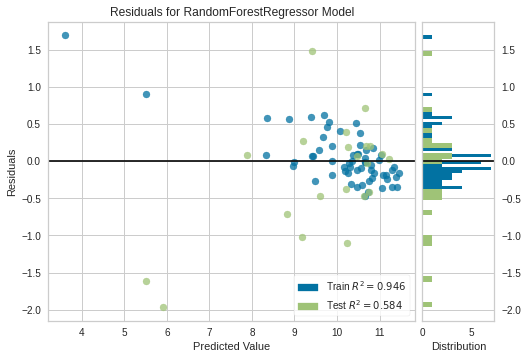

In [32]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=11,  random_state=86)
show_residusal(rf, train, test)

In [33]:
feature_importances(rf, x, 0.1)

  Feature                             Score
------------------------------------------------------------
| easting                             |0.12935111374237     |
------------------------------------------------------------
| permeability                        |0.12003789461556819  |
------------------------------------------------------------
| ppf                                 |0.4760935726042412   |
------------------------------------------------------------
| pr                                  |0.12156238855280192  |
------------------------------------------------------------


Lets see how these features correlate to our production

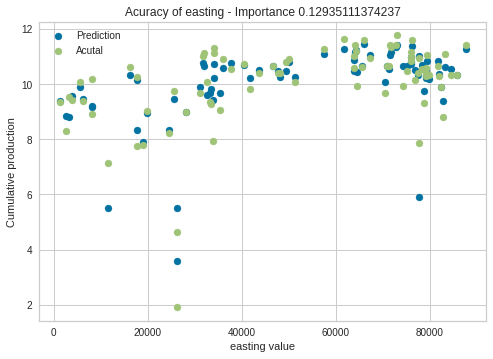

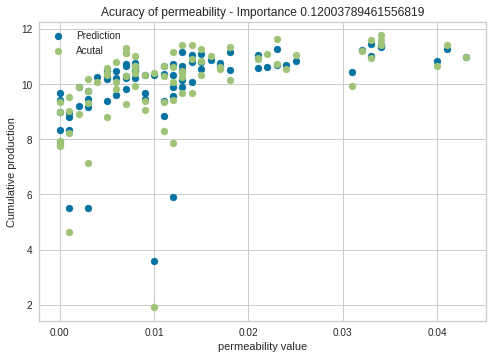

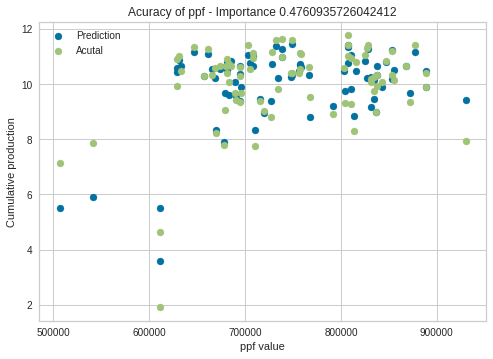

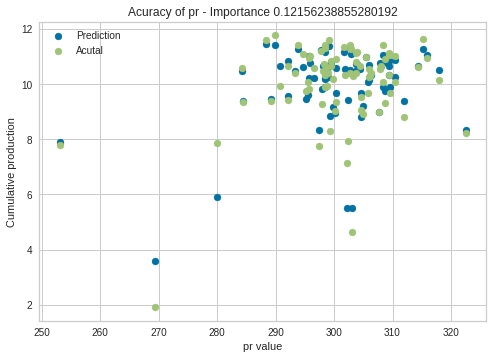

In [34]:
graph_accuracy_importances(x, y, rf, data, rf.feature_importances_)

Below we will see the differences between the regressor's predictions and the actual cumulative production

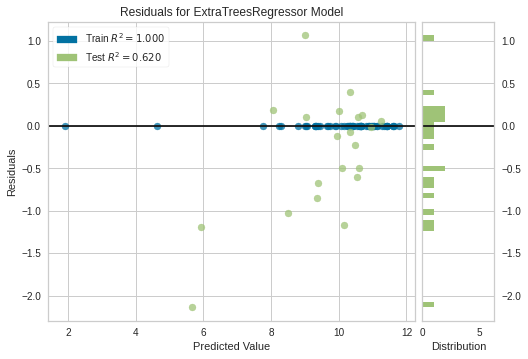

In [35]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(random_state=86)
show_residusal(etr, train, test)

In [36]:
feature_importances(etr, x)

  Feature                             Score
------------------------------------------------------------
| easting                             |0.15796966128138012  |
------------------------------------------------------------
| permeability                        |0.10344420140720699  |
------------------------------------------------------------
| ppf                                 |0.22447668418572217  |
------------------------------------------------------------
| pr                                  |0.22172454753237059  |
------------------------------------------------------------


Predict the following values:
- porosity
- perm
- Young 
- 

In [37]:
def create_regressor(data:pd.DataFrame, x_names: list, y_name:str):
    ds = clean_dataset(data)
    x = ds[x_names]
    y = ds[y_name]
    
    rf = RandomForestRegressor(random_state=86)
    rf.fit(x, y)
    return rf

In [38]:
vals = ["easting","ppf", "pr", "pump rate (cubic feet/min)",'pump rate (cubic feet/min)', 'proppant weight (lbs)', 'well length']
dicto = {}
optim = list(x.drop(vals, axis=1).keys())
for var in optim:
    reg = create_regressor(big_df.drop("Name", axis=1), ["easting", "northing"], var)
    dicto[var] = reg

The data here seems to be easily clusterable

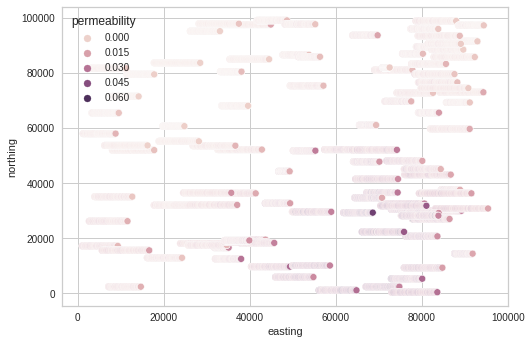

In [39]:
sns.scatterplot(data=big_df, x="easting", y="northing", hue="permeability")

# Stage 3: Choosing Parameters

We want to look at the
- [ ] Well Length
- [ ] Frac stage count
- [ ] Proppant per stage - Variable
- [ ] Pump rate per stage - Variable

In [57]:
!pip install tqdm

In [ ]:
def iterate_over(df, var_name, step=100):
    min_ = min(df[var_name])
    max_ = max(df[var_name])
    for i in np.arange(min_, max_, step):
        yield i

In [61]:
def iter_hypers():
    values = {}
    for north in iterate_over(data, "northing", step=1000):
        values["northing"] = north
        for east in iterate_over(data, "easting", step=1000):
            values["easting"] = north
            # Predict 
            for key in dicto.keys():
                arr = np.array([north, east]).reshape(1, -1)
                values[key] = dicto[key].predict( arr )
            for well in iterate_over(data, "well length"):
                values["well length"] = well
                for frac in iterate_over(data, "frac stages"):
                    values["frac stages"] = frac
                    for prop in iterate_over(data, "ppf"):
                        values["ppf"] = prop
                        for pump in iterate_over(data, "pr"):
                            values["pr"] = pump
                            yield pd.DataFrame(values)

In [ ]:
even_larger_daddy = pd.concat(iter_hypers())

In [ ]:
even_large_daddy.to_csv("biggerPoppa.csv", index=False)

# Stage 4: Well location

Graph all well locations

In [ ]:
sns.scatterplot(data=big_df, x="easting", y="northing", hue="easting")
plt.ylabel("Northing")
plt.xlabel("Easting")
plt.title("Location of Horizontal wells, starting position")
plt.legend('', frameon=False) # remove the legend
plt.show()

Change in water saturation

# Stage 5: The other params needed to make him happy